In [1]:
import sys

print(sys.path)
sys.path.append("../")

['/home/filippo/GarbageDetectionAndSegmentation/notebooks', '/home/filippo/anaconda3/envs/siv_regular/lib/python310.zip', '/home/filippo/anaconda3/envs/siv_regular/lib/python3.10', '/home/filippo/anaconda3/envs/siv_regular/lib/python3.10/lib-dynload', '', '/home/filippo/.local/lib/python3.10/site-packages', '/home/filippo/anaconda3/envs/siv_regular/lib/python3.10/site-packages']


In [2]:
!pip install imageio
!pip install joblib
!pip install opencv-python
!pip install matplotlib
!pip install scikit-image
!pip install scikit-learn
!pip install imutils

In [3]:
import imageio.v3 as iio
import joblib
import os

import random as rand
import numpy as np 
import cv2
import glob
import time

import matplotlib.pyplot as plt
%matplotlib inline

from utils import convert, show_images, put_boxes, box_boundaries
from featuresourcer import HogFeatureExtractor, CannyFeatureExtractor
from binaryclassifier import BinaryClassifier
from slider import Slider
from heatmap import HeatMap 
from segmenter import WatershedSegmenter

In [4]:
features = "hog"

In [5]:
if features == "canny":
    svc = joblib.load('../saved_models/canny_svc.pkl')
    scaler = joblib.load('../saved_models/canny_scaler.pkl')
    sourcer_params = {
      'color_model': 'hls',                # hls, hsv, yuv, ycrcb
      'bounding_box_w': 64,             #
      'bounding_box_h' : 48,
      'first_thresh': 10,             #
      'second_thresh' : 200,
    }
elif features == "hog":
    svc = joblib.load('../saved_models/hog_svc.pkl')
    scaler = joblib.load('../saved_models/hog_scaler.pkl')
    sourcer_params = {
      'color_model': 'hls',                # hls, hsv, yuv, ycrcb
      'bounding_box_w': 64,             #
      'bounding_box_h' : 48,
      'number_of_orientations': 12,        # 6 - 12
      'pixels_per_cell': 8,               # 8, 16
      'cells_per_block': 2,                # 1, 2
      'do_transform_sqrt': True
    }

In [6]:
def heatmap_test(image, this_heatmap):
  this_heatmap.reset()

  bounding_boxes = slider.locate(image = image)
  this_heatmap.update(bounding_boxes)
  this_heatmap.show(image)

In [7]:
cls = BinaryClassifier(svc, scaler)

WINDOW SIZE  64   48


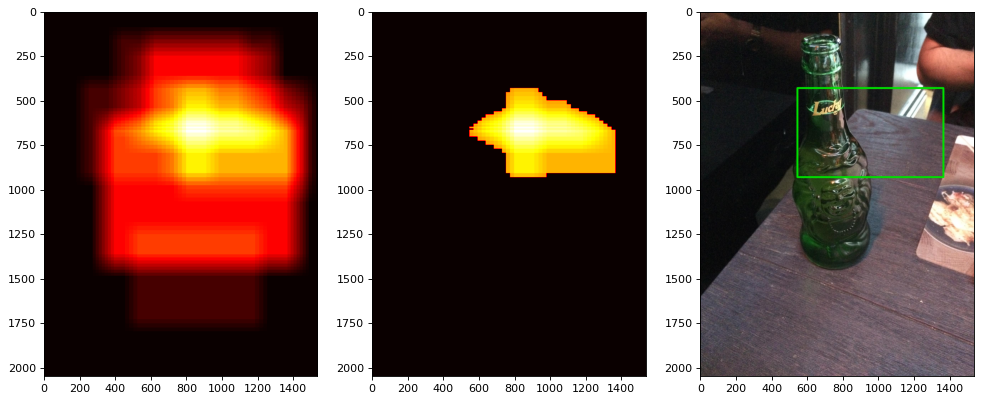

 REGION SHAPE  (500, 819, 3)
WINDOW SIZE  64   48


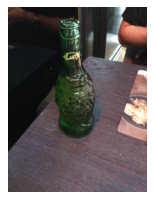

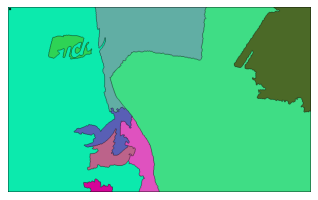

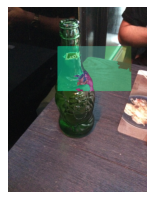

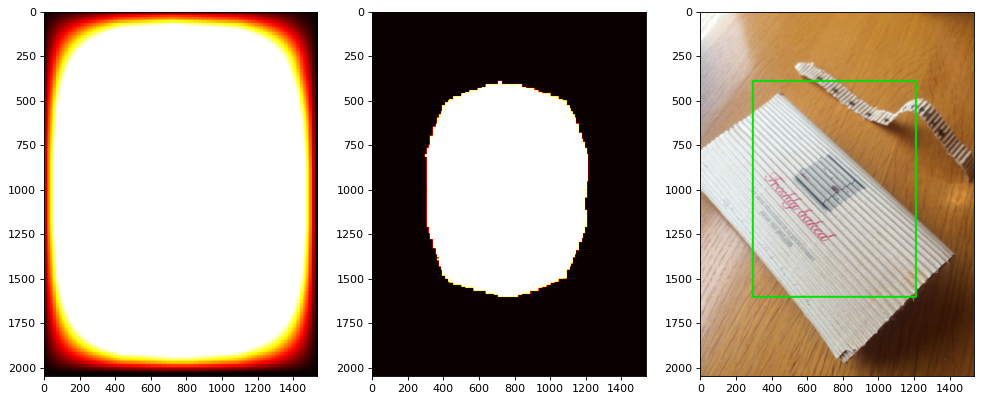

 REGION SHAPE  (1212, 915, 3)
WINDOW SIZE  64   48


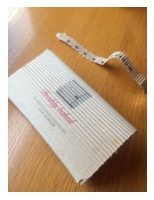

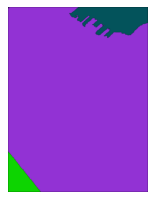

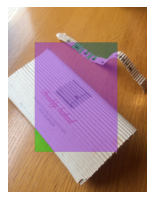

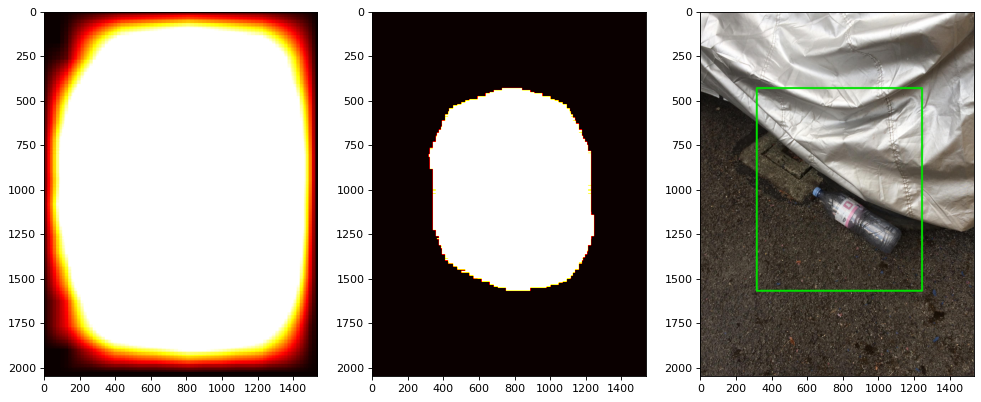

 REGION SHAPE  (1138, 927, 3)
WINDOW SIZE  64   48


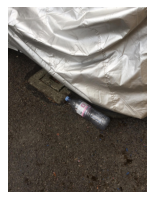

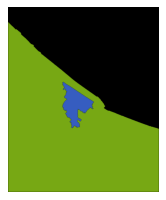

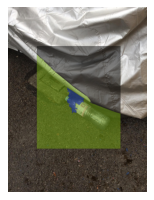

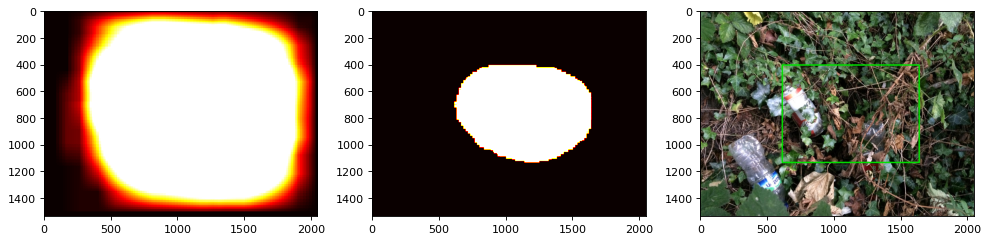

 REGION SHAPE  (727, 1024, 3)
WINDOW SIZE  64   48


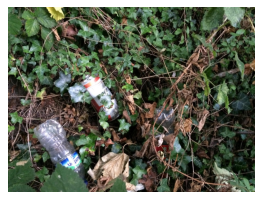

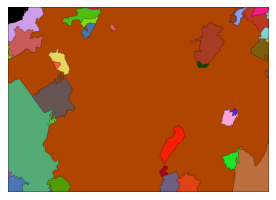

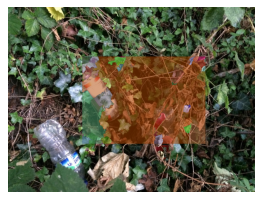

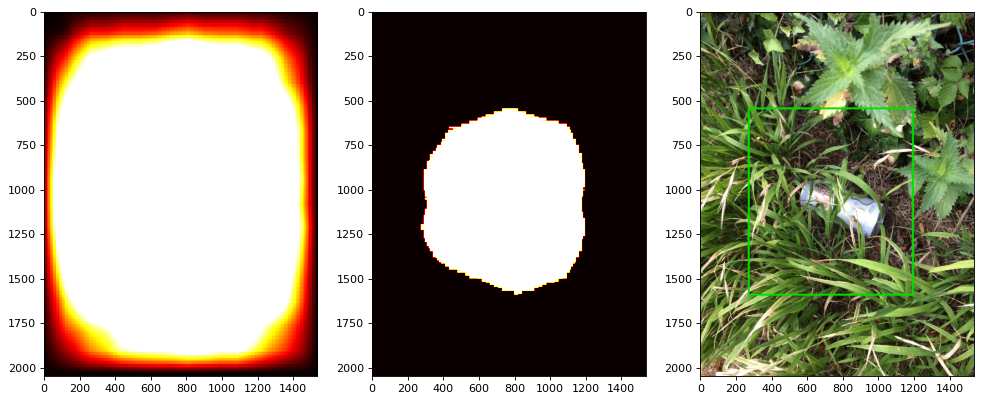

In [ ]:
path = "../data/test"
subdirs = [x[0] for x in os.walk(path)]                                                                            
for subdir in subdirs:                                                                                            
    files = os.walk(subdir).__next__()[2]                                                                             
    if (len(files) > 0):                                                                                          
        for file in files:    
            img_path = os.path.join(subdir,file)
            if(features == "canny"):
                src = CannyFeatureExtractor(sourcer_params, iio.imread(img_path))
            elif(features == "hog"):
                src = HogFeatureExtractor(sourcer_params, iio.imread(img_path))

            slider = Slider(sourcer = src, classifier = cls, increment = 32)

            img1 = iio.imread(img_path)

            heatmap = HeatMap(frame = img1, memory = 4)
            heatmap_test(img1, heatmap)
            
            object_proposals = heatmap.get_final_bounding_boxes()
            
            segmenter = WatershedSegmenter(img1, object_proposals)
            show_images([img1], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
            segmented_object_proposals = segmenter.segment_object_proposals()
            show_images([segmented_object_proposals[0]], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
            final_image= segmenter.build_final_image(segmented_object_proposals)
            show_images([final_image], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)